# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

import quandl

In [3]:
from utils import *

In [5]:
api_key = open(file='quandl_api').read().replace('\n', '')
quandl.ApiConfig.api_key = api_key
tickers, prices = get_quandl_sharadar(download=True)

In [6]:
prices

,,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated
Ticker,Date,,,,,,,,
AAPL,1998-12-31,1.446,1.478,1.411,1.462,67922400.0,0.0,40.94,2018-06-19
AXP,1998-12-31,34.967,35.100,34.100,34.167,2528700.0,0.0,102.50,2018-02-11
BA,1998-12-31,31.750,33.130,31.630,32.630,7343500.0,0.0,32.63,2018-02-11
CAT,1998-12-31,23.000,23.940,23.000,23.000,4147400.0,0.0,46.00,2018-02-11
CSCO,1998-12-31,23.220,23.500,22.953,23.250,29021600.0,0.0,93.00,2018-02-11
...,...,...,...,...,...,...,...,...,...
UNH,2018-07-10,254.180,256.900,253.750,255.540,1977592.0,0.0,255.54,2018-07-10
UTX,2018-07-10,126.840,128.170,126.555,127.060,3063885.0,0.0,127.06,2018-07-10
VZ,2018-07-10,50.800,51.420,50.740,51.340,9458492.0,0.0,51.34,2018-07-10


# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

4698 days.


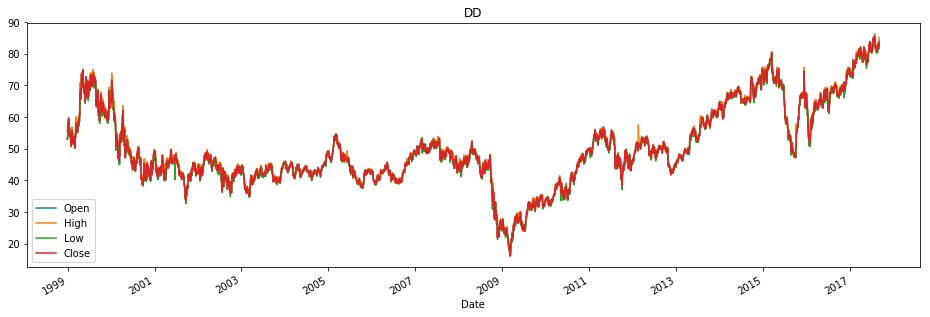

In [212]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [213]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [214]:
N = 60
f_sma = np.ones(N) / N

### Gaussian

In [215]:
f_ga = gaussian(N, N/3)
f_ga = f_ga / f_ga.sum()

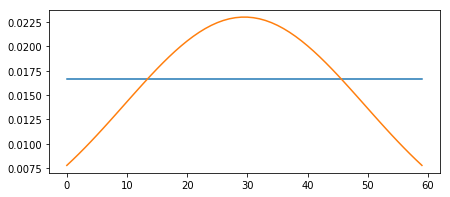

In [216]:
plt.figure(figsize=(7, 3))
plt.plot(f_sma, label='f_sma')
plt.plot(f_ga, label='f_ga')
plt.show()

### Wiener 

In [217]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [218]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

<Figure size 1152x432 with 0 Axes>

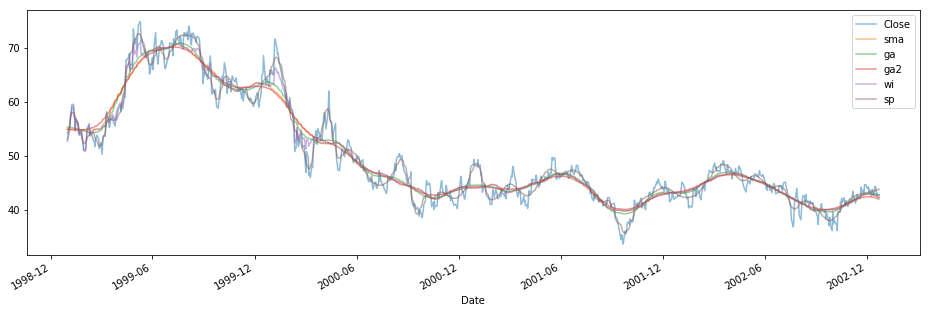

In [219]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(sma=filters.convolve1d(price.Close, f_sma),
                                  ga=filters.convolve1d(price.Close, f_ga),
                                  ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
                                  wi=f_wi(price.Close),
                                  sp=f_sp(price.Close))
results[:1000].plot(alpha=0.5);

<Figure size 1152x432 with 0 Axes>

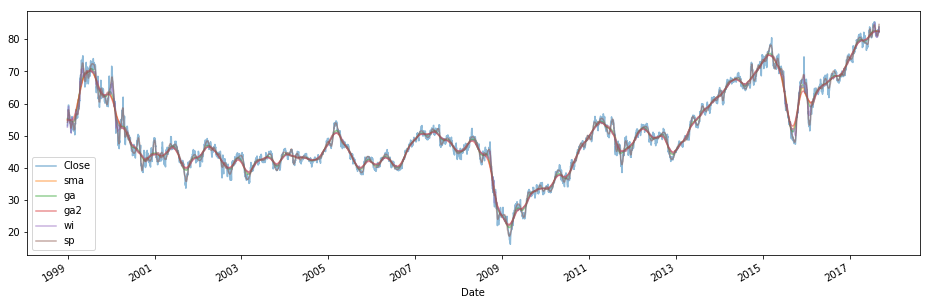

In [220]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

## Trends 

### Peaks and Valleys

In [221]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [222]:
results = results.assign(smoothed=results.ga2)
# results = results[:1000]

In [223]:
peaks, _ = find_peaks(results.smoothed)
valleys, _ = find_peaks(-results.smoothed)

In [224]:
results = results.assign(Trend=np.nan)

In [225]:
results.Trend[0] = np.sign(valleys.min() - peaks.min())

In [226]:
results['Trend'][peaks + 1] = -1
results['Trend'][valleys + 1] = 1
results.Trend.fillna(method='ffill', inplace=True)

In [227]:
results

,Close,sma,ga,ga2,wi,sp,smoothed,Trend
Date,,,,,,,,
1998-12-31,53.06,54.943833,55.320827,54.884693,52.634916,54.170356,54.884693,-1.0
1999-01-04,55.25,54.923000,55.305515,54.883574,54.801568,55.503137,54.883574,-1.0
1999-01-05,56.69,54.876167,55.274384,54.881422,56.229613,56.523181,54.881422,-1.0
1999-01-06,58.13,54.858500,55.252130,54.878219,57.655744,57.257653,54.878219,-1.0
1999-01-07,57.94,54.823000,55.218730,54.873891,57.479299,57.733723,54.873891,-1.0
...,...,...,...,...,...,...,...,...
2017-08-25,82.66,82.526833,82.377296,82.522563,82.401023,82.261901,82.522563,-1.0
2017-08-28,82.88,82.529333,82.366940,82.521953,82.611096,82.719570,82.521953,-1.0
2017-08-29,82.24,82.554167,82.369826,82.521582,81.967105,83.264307,82.521582,-1.0


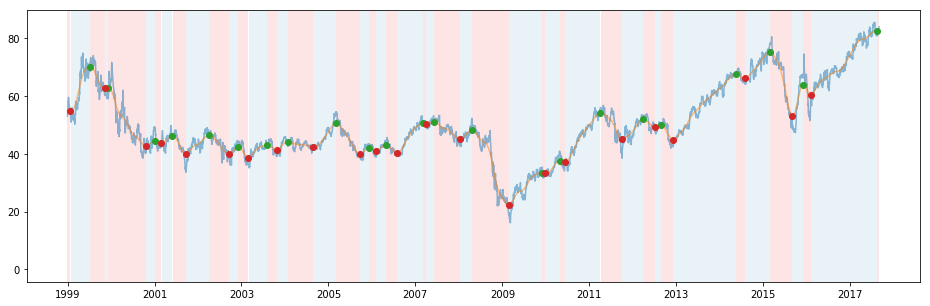

In [228]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['smoothed'], 'o', label='valleys')
plt.show()

### Slopes

In [229]:
results = results.assign(Trend2=results.smoothed.pct_change().apply(np.sign))
results.Trend2[0] = results.Trend2[1]

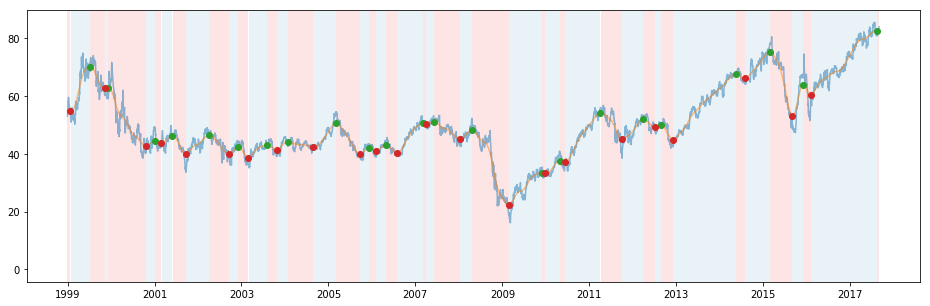

In [230]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['smoothed'], 'o', label='valleys')
plt.show()

In [231]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

array([[0.42209451, 0.        ],
       [0.        , 0.57790549]])

> Both methods are equivalent!!